In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow_probability.substrates.jax as tfp
import pylab as plt

from essm_jax.essm import ExtendedStateSpaceModel

tfpd = tfp.distributions


Let's define a non-linear transition function that forces the state proportionally to its magnitude,

$$p(z_{t+1} | z_t, t) = \mathcal{N}[T(z_t, t), \sigma_t^2]$$

with,

$$T(z_t, t) = z_t \left(1 + |z_t| \sin \left(2 \pi \frac{t}{10}\right)\right)$$

and 

$$\sigma_t = 0.1$$

Now for the observation function, let's define also a non-linear one, that takes the absolute value.

$$p(x_t | z_t, t) = \mathcal{N}[O(z_t, t), \epsilon_t^2]$$

with 

$$O(z_t, t) = |z_t|$$

and noise that oscillates with time,

$$\epsilon_t = 0.01 + 0.1 \cos\left(2\pi \frac{t}{5}\right)$$


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


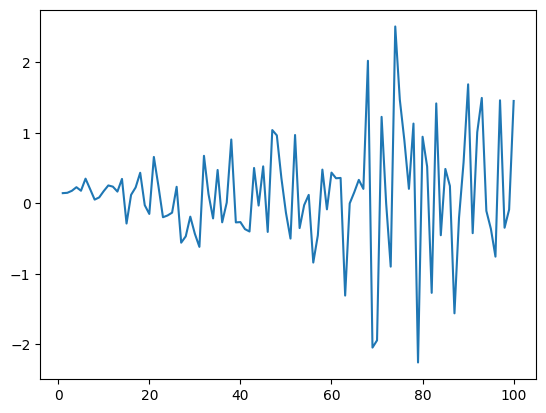

In [2]:


def transition_fn(z, t, t_next):
    mean = z * (1 + jnp.abs(z) * jnp.sin(2 * jnp.pi * t / 10))
    scale = 0.01 * jnp.ones(np.size(z))
    return tfpd.MultivariateNormalDiag(mean, scale)


def observation_fn(z, t):
    mean = jnp.abs(z)
    scale = 0.001 * jnp.ones(np.size(z)) + 0.01 * (2 * jnp.pi * t / 5.)
    return tfpd.MultivariateNormalDiag(mean, scale)


n = 1

initial_state_prior = tfpd.MultivariateNormalDiag(jnp.zeros(n), jnp.ones(n))

essm = ExtendedStateSpaceModel(
    transition_fn=transition_fn,
    observation_fn=observation_fn,
    initial_state_prior=initial_state_prior,
    more_data_than_params=False,  # if observation is bigger than latent we can speed it up.
    dt=1.
)
samples = essm.sample(jax.random.PRNGKey(0), 100)

plt.plot(samples.t, samples.observation)
plt.show()

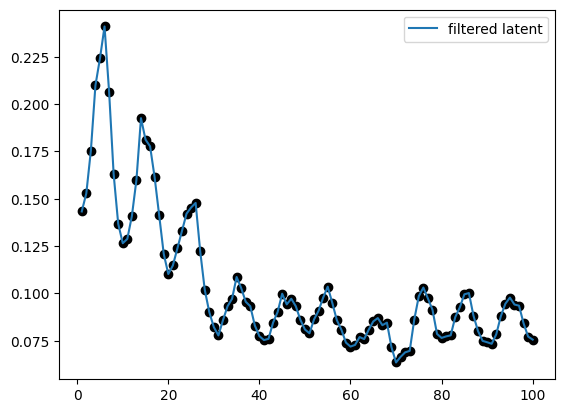

In [3]:

filter_result = essm.forward_filter(samples.observation)

filter_state = essm.create_initial_filter_state()


for i in range(100):
    filter_state = essm.incremental_predict(filter_state)
    # incorperate new data
    filter_state, _ = essm.incremental_update(filter_state, samples.observation[i])
    
    plt.scatter(filter_state.t, filter_state.filtered_mean, c='black')
    

plt.plot(filter_result.t, filter_result.filtered_mean[:, 0], label='filtered latent')
plt.legend()
plt.show()